---
# Import Libraries

In [1]:
import os
import sys

In [2]:
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

In [3]:
sys.path.append("../../../deep-learning-dna")
sys.path.append("../")
sys.path.append("../../../deep-learning-dna/common")

In [4]:
import wandb

In [205]:
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import math
import string

from Attention import Set_Transformer
from common.models import dnabert
from common import dna
from lmdbm import Lmdb
from common.data import DnaSequenceGenerator, DnaLabelType, DnaSampleGenerator, find_dbs
import wandb

import tf_utils as tfu

In [6]:
strategy = tfu.devices.select_gpu(0, use_dynamic_memory=True)

---
# Load Data

In [109]:
def gen_data(batch_size, length=5):
    x = np.random.randint(1, 100, (batch_size, length))
    y = np.argmax(x, axis = 1)
    return x, y # (batch_size, length)

In [110]:
x, y = gen_data(3, 5)

In [111]:
print(x.shape, y.shape)

(3, 5) (3,)


In [112]:
x

array([[51, 47, 97, 19, 74],
       [43, 43,  9, 37, 11],
       [20, 40, 25, 10, 17]])

In [113]:
y

array([2, 0, 1])

---
# Cache Memory

In [114]:
def Cache_Memory(current_state, previous_state, memory_length):
    
    if memory_length is None or memory_length == 0:
        return None
    else:
        if previous_state is None:
            new_mem = current_state[:, -memory_length:, :]
        else:
            new_mem = tf.concat(
                    [previous_state, current_state], 1)[:, -memory_length:, :]

    return tf.stop_gradient(new_mem)

---
# Attention

In [115]:
class Attention(keras.Model):
    def __init__(self, num_induce, embed_dim, num_heads, use_layernorm, pre_layernorm, use_keras_mha):
        super(Attention, self).__init__()
        
        self.num_induce = num_induce
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.use_layernorm = use_layernorm
        self.pre_layernorm = pre_layernorm
        self.use_keras_mha = use_keras_mha
        
        if self.num_induce == 0:       
            self.attention = (Set_Transformer.SetAttentionBlock(embed_dim=self.embed_dim, num_heads=self.num_heads, use_layernorm=self.use_layernorm,pre_layernorm=self.pre_layernorm,use_keras_mha=self.use_keras_mha))
        else:
            self.attention = Set_Transformer.InducedSetAttentionBlock(embed_dim=self.embed_dim, num_heads=self.num_heads, num_induce=self.num_induce, use_layernorm=self.use_layernorm, pre_layernorm=self.pre_layernorm, use_keras_mha=self.use_keras_mha)
    
    
    def call(self, data, mems):
                
            attention = self.attention([data, mems])
                
            return attention

---
# XL Block

In [116]:
class TransformerXLBlock(tf.keras.layers.Layer):
    def __init__(self,
                 num_induce, 
                 embed_dim,
                 num_heads,
                 use_layernorm,
                 pre_layernorm,
                 use_keras_mha,):

        super(TransformerXLBlock, self).__init__()
        
        self.num_induce = num_induce
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.use_layernorm = use_layernorm
        self.pre_layernorm = pre_layernorm
        self.use_keras_mha = use_keras_mha
        
        self.attention = Attention
        
        self.attention_layer = self.attention(self.num_induce, self.embed_dim, self.num_heads, self.use_layernorm, self.pre_layernorm, self.use_keras_mha)

   
    def call(self,
             content_stream,
             state=None):
        
        attention_output = self.attention_layer(content_stream, state)

        return attention_output

---
# Transformer XL

In [117]:
class TransformerXL(tf.keras.layers.Layer):
    def __init__(self,
                 mem_switched, 
                 num_layers,
                 num_induce,
                 embed_dim,
                 num_heads,
                 dropout_rate,
                 mem_len=None,
                 use_layernorm=True,
                 pre_layernorm=True, 
                 use_keras_mha=True):
        
        super(TransformerXL, self).__init__()

        self.mem_switched = mem_switched
        self.num_layers = num_layers
        self.num_induce = num_induce
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.dropout_rate = dropout_rate
        self.mem_len = mem_len
        self.use_layernorm = use_layernorm
        self.pre_layernorm = pre_layernorm
        self.use_keras_mha = use_keras_mha

        self.transformer_xl_layers = []
        
        for i in range(self.num_layers):
            self.transformer_xl_layers.append(
                    TransformerXLBlock(self.num_induce,
                                        self.embed_dim,
                                        self.num_heads,
                                        self.use_layernorm,
                                        self.pre_layernorm, 
                                        self.use_keras_mha))

        self.output_dropout = tf.keras.layers.Dropout(rate=self.dropout_rate)

    def call(self,
             content_stream,
             state=None):
        
        new_mems = []

        if state is None:
            state = [None] * self.num_layers
            
        for i in range(self.num_layers):
            if self.mem_switched == False:
                new_mems.append(Cache_Memory(content_stream, state[i], self.mem_len))
            
            transformer_xl_layer = self.transformer_xl_layers[i]
            
            transformer_xl_output = transformer_xl_layer(content_stream=content_stream,
                                                        state=state[i])
            
            content_stream = self.output_dropout(transformer_xl_output)
            
            if self.mem_switched == True:
                new_mems.append(Cache_Memory(content_stream, state[i], self.mem_len))

        output_stream = content_stream
        return output_stream, new_mems

---
# Xl Model Class

In [172]:
class XlModel(keras.Model):
    def __init__(self, mem_switched, max_files, encoder, block_size, max_set_len, num_induce, embed_dim, num_layers, num_heads, mem_len, dropout_rate, num_seeds, use_layernorm, pre_layernorm, use_keras_mha):
        super(XlModel, self).__init__()
        
        self.mem_switched = mem_switched
        self.max_files = max_files
        self.encoder = encoder
        self.block_size = block_size
        self.max_set_len = max_set_len
        self.num_induce = num_induce
        self.embed_dim = embed_dim
        self.num_layers = num_layers
        self.num_heads = num_heads
        self.mem_len = mem_len
        self.dropout_rate = dropout_rate
        self.num_seeds = num_seeds
        self.use_layernorm = use_layernorm
        self.pre_layernorm = pre_layernorm
        self.use_keras_mha = use_keras_mha
        
        self.linear_layer = keras.layers.Dense(self.embed_dim)
        
        self.transformer_xl = TransformerXL(self.mem_switched,
                                            self.num_layers,
                                             self.num_induce,
                                             self.embed_dim,
                                             self.num_heads,
                                             self.dropout_rate,
                                             self.mem_len,
                                             self.use_layernorm,
                                             self.pre_layernorm,
                                             self.use_keras_mha)
        

        self.pooling_layer = Set_Transformer.PoolingByMultiHeadAttention(num_seeds=self.num_seeds,embed_dim=self.embed_dim,num_heads=self.num_heads,use_layernorm=self.use_layernorm,pre_layernorm=self.pre_layernorm, use_keras_mha=self.use_keras_mha, is_final_block=True)
    
        self.dropout_layer = keras.layers.Dropout(.5)
    
        #self.dense_layer = keras.layers.Dense(1) 
        self.dense_layer = keras.layers.Dense(100) 

    def call(self, x, training=None):    
 
        mems = tf.zeros((self.num_layers, tf.shape(x)[0], self.mem_len, self.embed_dim))
    
        x = tf.expand_dims(x, axis=2)
        
        linear_transform = self.linear_layer(x)

        for i in range(0, self.max_set_len, self.block_size):

            block = linear_transform[:,i:i+self.block_size]
            
            output, mems = self.transformer_xl(content_stream=block, state=mems)

        pooling = self.pooling_layer(output)
        
        dropout = self.dropout_layer(pooling)

        dense = self.dense_layer(dropout)

        output = tf.reshape(dense, tf.shape(dense)[::2])         
        
        return output

---
# Xl Parameters

In [173]:
#Xl Parameters
max_files = 0
encoder = 0
mem_switched = True
num_induce = 0
embed_dim = 64
num_layers = 4
num_heads = 8
mem_len = 0
dropout_rate = 0.01
num_seeds = 1
use_layernorm = True
pre_layernorm = True
use_keras_mha = True

---
# Create Models

In [174]:
block_size = 20
length = 20

In [222]:
x, y = gen_data(batch_size=10, length=length)
vx, vy = gen_data(batch_size=10, length=length)

In [223]:
max_set_len = length
set_len = length

In [224]:
model = XlModel(mem_switched, max_files, encoder, block_size, max_set_len, num_induce, embed_dim, num_layers, num_heads, mem_len, dropout_rate, num_seeds, use_layernorm, pre_layernorm, use_keras_mha)
model.compile(loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer = keras.optimizers.Adam(1e-3), metrics = keras.metrics.SparseCategoricalAccuracy())

In [225]:
y[:5]

array([ 6, 15, 10, 10, 17])

In [226]:
tf.argmax(model.predict(x[:5]), axis = 1)

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([4, 4, 4, 4, 4])>

In [227]:
epochs = 500

In [228]:
history = model.fit(x, y, validation_data=(vx, vy), epochs=epochs, verbose=1)

Epoch 1/500
1/1 [==============================] - 7s 7s/step - loss: 6.2909 - sparse_categorical_accuracy: 0.0000e+00 - val_loss: 4.7156 - val_sparse_categorical_accuracy: 0.1000
Epoch 2/500
1/1 [==============================] - 0s 77ms/step - loss: 4.1853 - sparse_categorical_accuracy: 0.0000e+00 - val_loss: 4.5154 - val_sparse_categorical_accuracy: 0.1000
Epoch 3/500
1/1 [==============================] - 0s 66ms/step - loss: 4.3912 - sparse_categorical_accuracy: 0.0000e+00 - val_loss: 4.4024 - val_sparse_categorical_accuracy: 0.1000
Epoch 4/500
1/1 [==============================] - 0s 71ms/step - loss: 4.0849 - sparse_categorical_accuracy: 0.1000 - val_loss: 4.3501 - val_sparse_categorical_accuracy: 0.2000
Epoch 5/500
1/1 [==============================] - 0s 71ms/step - loss: 3.6734 - sparse_categorical_accuracy: 0.1000 - val_loss: 4.2996 - val_sparse_categorical_accuracy: 0.2000
Epoch 6/500
1/1 [==============================] - 0s 67ms/step - loss: 3.6299 - sparse_categorical_

In [229]:
acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']

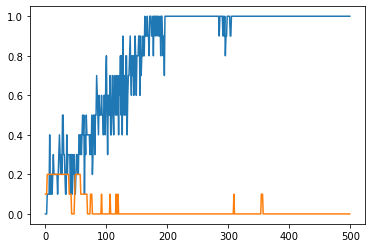

In [230]:
plt.plot(acc)
plt.plot(val_acc)

In [231]:
#Training

In [232]:
x[:5]

array([[80, 28, 85, 64, 57, 13, 98, 92, 95, 66, 58, 77, 67, 74, 59, 33,
         3, 64,  5, 53],
       [60, 46, 54, 29, 59, 55, 28, 72, 47, 41, 67, 66, 71,  8, 30, 99,
        25, 62, 84, 30],
       [77, 33, 34, 64, 83, 62, 17, 72, 94, 20, 95,  3, 16, 17,  2, 39,
         1, 66, 10, 66],
       [57, 85, 10, 70, 26, 46, 56, 29, 18, 34, 88, 68, 20, 87, 66, 84,
        56, 27, 82, 23],
       [59, 83, 59, 85, 65,  8, 11, 77, 49, 72, 87, 72, 28, 76,  2, 69,
        26, 95, 59, 67]])

In [233]:
y[:5]

array([ 6, 15, 10, 10, 17])

In [234]:
tf.argmax(model.predict(x[:5]), axis = 1)

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([ 6, 15, 10, 10, 17])>

In [235]:
#Validation

In [236]:
x, y = gen_data(batch_size=30, length=10)

In [237]:
y[:5]

array([5, 1, 0, 8, 4])

In [238]:
tf.argmax(model.predict(x[:5]), axis = 1)

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([18, 17, 10, 17,  6])>